# NBA Shot Quality vs. Shot-Making (xFG%)
Portfolio-ready pipeline for shot charts, xFG% modeling, and calibration.



> **How to use this notebook**
>
> - Choose one data source:
>   1) Kaggle: Download the 2014–15 NBA shot logs CSV and set `KAGGLE_SHOTS_PATH`.
>   2) NBA Stats API: Install `nba_api` and use `fetch_shots_from_nba_api(...)`.
>
> - Then run: preprocess → feature engineering → modeling → evaluation → visuals.
> - Outputs are saved in `outputs/`.
> - Respect NBA.com Terms of Use when scraping/downloading.


# NBA Shot Quality vs. Shot-Making (xFG%)

Portfolio-ready pipeline that loads NBA shots (NBA Stats API or Kaggle CSV), normalizes to one half-court, engineers features, trains an xFG% model (LogReg + GBT), evaluates (Brier, LogLoss, Calibration), and plots:

- Shot frequency **hexbin**
- **xFG% heatmap** (shot quality)
- **Shot-making table**: Actual FG% − xFG% per player

**How to run**
1) Make sure you’ve installed: `pip install pandas numpy matplotlib scikit-learn nba_api tqdm`
2) Scroll to **End-to-End Run** and execute that cell (or Run All).


In [47]:
import sys, numpy, pandas, matplotlib, sklearn
print(sys.executable)
print("numpy", numpy.__version__)
print("pandas", pandas.__version__)
print("matplotlib", matplotlib.__version__)
print("sklearn", sklearn.__version__)


e:\Downloads\nbaxfg\.venv\Scripts\python.exe
numpy 2.3.2
pandas 2.3.1
matplotlib 3.10.5
sklearn 1.7.1


In [48]:
import numpy as np, pandas as pd
import pandas as pd


In [49]:
# %% [markdown]
# ## Setup

# %%
# %pip install pandas numpy matplotlib scikit-learn nba_api tqdm

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss, log_loss
from sklearn.calibration import calibration_curve

from tqdm import tqdm

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


In [50]:
# --- DEMO MODE (synthetic sample) ---
import numpy as np, pandas as pd

np.random.seed(42)
n = 2000
# random shots biased toward rim and corners
x = np.concatenate([
    np.random.normal(0, 4.0, size=n//2),         # center cluster
    np.random.choice([-22, 22], size=n//2) + np.random.normal(0, 1.5, size=n//2)  # corners
])
y = np.abs(np.random.beta(2, 5, size=n)) * 47   # 0 to 47 ft half-court
made_prob = 0.65 * np.exp(-(np.sqrt(x**2 + y**2)-3)/14)  # distance decay heuristic
made_prob = np.clip(made_prob, 0.05, 0.75)
made = (np.random.rand(n) < made_prob).astype(int)

raw = pd.DataFrame({
    "LOC_X": x / 0.1,   # pretend tenths-of-feet like nba_api (will be rescaled)
    "LOC_Y": y / 0.1,
    "SHOT_MADE_FLAG": made,
    "PERIOD": np.random.randint(1,5,size=n),
    "SHOT_CLOCK": np.random.uniform(0,24,size=n),
    "PLAYER_NAME": np.random.choice(["Player A","Player B","Player C"], size=n)
})

# Continue with normalize + features in the notebook


In [51]:
season = "2024-25"

# Example: team pull (Boston)
example_team_id = 1610612738  # BOS
raw = fetch_shots_from_nba_api(season=season, team_id=example_team_id)

# OR player pull:
# from nba_api.stats.static import players
# p = players.find_players_by_full_name("Jayson Tatum")[0]
# raw = fetch_shots_from_nba_api(season=season, player_id=p["id"])


## 1) Data Source: NBA Stats API

We used the `nba_api` Python package to pull **shot chart detail data** from the official NBA Stats API.

**Season:** 2024–25  
**Endpoint:** `ShotChartDetail`  
**Filters:** Example team + league-wide shots.

The dataset contains:  
- **x, y coordinates** of each shot  
- Make/Miss flag (`SHOT_MADE_FLAG`)  
- Shooter details  
- Game context (period, minutes remaining, etc.)

These features are then cleaned and transformed for modeling.

In [52]:
# %% [markdown]
# ## 1) Load Data

# %%
# Optional Kaggle CSV path (leave "" if using NBA API)
KAGGLE_SHOTS_PATH = ""  # e.g., r"E:\Data\nba\shot_logs.csv"

def load_kaggle_shot_logs(csv_path: str) -> pd.DataFrame:
    """2014–15 SportVU shot logs CSV. Normalizes column names to UPPER."""
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().upper() for c in df.columns]
    return df

def kaggle_basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "SHOT_RESULT" in df.columns:
        df["SHOT_MADE_FLAG"] = (df["SHOT_RESULT"].str.upper() == "MADE").astype(int)
    if "SHOT_DIST" in df.columns:
        df["SHOT_DIST_FT"] = pd.to_numeric(df["SHOT_DIST"], errors="coerce")
    return df

# --- NBA API loader (recommended) ---
try:
    from nba_api.stats.endpoints import ShotChartDetail
    NBA_API_AVAILABLE = True
except Exception:
    NBA_API_AVAILABLE = False

def fetch_shots_from_nba_api(season: str = "2024-25",
                             player_id: int | None = None,
                             team_id: int | None = None) -> pd.DataFrame:
    """
    Pulls shot chart detail data from NBA Stats for a season and optional player/team.
    Uses 'FGA' to return all attempts with SHOT_MADE_FLAG available.
    """
    if not NBA_API_AVAILABLE:
        raise RuntimeError("nba_api not installed/available. Run: pip install nba_api")

    params = dict(
        season_nullable=season,
        player_id=player_id or 0,
        team_id=team_id or 0,
        context_measure_simple="FGA",   # key: get attempts (not just makes)
    )
    shots = ShotChartDetail(**params, timeout=30).get_data_frames()[0]
    return shots


## 2) Visualizing Shot Data

We begin by visualizing **shot frequency** and **model-predicted xFG%** using half-court hexbin and heatmap plots.

- **Hexbin Frequency Map** – brighter zones = more frequent shots.
- **xFG% Heatmap** – brighter zones = higher predicted FG%.

These visuals give a quick glance at shot distribution and efficiency across the court.

In [53]:
# %% [markdown]
# ## 2) Preprocess & Normalize to One Half-Court

# %%
COURT_WIDTH_FT = 50.0
HALF_COURT_LENGTH_FT = 47.0
THREE_ARC_RADIUS_FT = 23.75
CORNER_LINE_DIST_FT = 22.0
CORNER_LINE_LENGTH_FT = 14.0

def infer_feet_scale(x: np.ndarray, y: np.ndarray) -> float:
    """Guess whether coords are inches, tenths-of-feet, or feet."""
    r = np.sqrt(x**2 + y**2)
    p95 = np.nanpercentile(r, 95)
    if p95 > 300:        # likely inches
        return 1/12.0
    if 80 < p95 <= 300:  # likely tenths-of-feet (common from NBA API)
        return 0.1
    return 1.0           # already feet

def normalize_shot_coords(df: pd.DataFrame, x_col="LOC_X", y_col="LOC_Y") -> pd.DataFrame:
    df = df.copy()
    if x_col not in df.columns or y_col not in df.columns:
        return df
    x = pd.to_numeric(df[x_col], errors="coerce").to_numpy()
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy()
    y = np.abs(y)  # reflect to attacking half
    scale = infer_feet_scale(x, y)
    df["X_FT"] = x * scale
    df["Y_FT"] = y * scale
    return df


## 3) Modeling Approach

We train a **Gradient Boosted Trees (GBT)** model to predict `SHOT_MADE_FLAG` (1 = made, 0 = missed) based only on shot coordinates.

**Workflow:**
1. **Feature Assembly** – use `(LOC_X, LOC_Y)` as inputs.
2. **Train/Test Split** – 75% training, 25% testing.
3. **Model Training** – fit GBT model on training set.
4. **Prediction** – generate xFG% for test shots.
5. **Calibration & Error Analysis** – evaluate how well predicted probabilities match reality.

In [54]:

# %% [markdown]
# ## 3) Feature Engineering

# %%
def compute_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Distance and angle
    if {"X_FT","Y_FT"}.issubset(df.columns):
        df["shot_distance_ft"] = np.sqrt(df["X_FT"]**2 + df["Y_FT"]**2)
        df["shot_angle_deg"]   = np.degrees(np.arctan2(df["X_FT"], df["Y_FT"] + 1e-9))
    elif "SHOT_DIST_FT" in df.columns:
        df["shot_distance_ft"] = pd.to_numeric(df["SHOT_DIST_FT"], errors="coerce")
        df["shot_angle_deg"]   = np.nan
    else:
        df["shot_distance_ft"] = np.nan
        df["shot_angle_deg"]   = np.nan

    # Three & corner three
    x = df.get("X_FT", pd.Series(np.nan, index=df.index)).astype(float)
    y = df.get("Y_FT", pd.Series(np.nan, index=df.index)).astype(float)
    is_corner_region = (np.abs(x) >= (COURT_WIDTH_FT/2 - 3.0)) & (y <= CORNER_LINE_LENGTH_FT)
    is_three_arc     = (df["shot_distance_ft"] >= THREE_ARC_RADIUS_FT)
    is_three_corner  = is_corner_region & (df["shot_distance_ft"] >= CORNER_LINE_DIST_FT - 0.25)

    df["is_corner_3"] = (is_corner_region & (df["shot_distance_ft"] >= CORNER_LINE_DIST_FT - 0.25)).astype(int)
    df["is_three"]    = (is_three_arc | is_three_corner).astype(int)

    # Period
    df["period"] = pd.to_numeric(df.get("PERIOD", np.nan), errors="coerce").astype("Int64")

    # Shot clock bins (if available)
    if "SHOT_CLOCK" in df.columns:
        sc = pd.to_numeric(df["SHOT_CLOCK"], errors="coerce")
        df["shot_clock_bin"] = pd.cut(sc, bins=[-1,4,7,14,24], labels=["0-4","4-7","7-14","14-24"])
    else:
        df["shot_clock_bin"] = pd.Categorical([np.nan]*len(df), categories=["0-4","4-7","7-14","14-24"])

    # Optional features
    for col in ["DRIBBLES","TOUCH_TIME","CLOSE_DEF_DIST"]:
        if col in df.columns:
            df[col.lower()] = pd.to_numeric(df[col], errors="coerce")

    return df

def assemble_feature_matrix(df: pd.DataFrame):
    cols = ["shot_distance_ft","shot_angle_deg","is_three","is_corner_3","period"]
    for c in ["dribbles","touch_time","close_def_dist"]:
        if c in df.columns:
            cols.append(c)

    X = df[cols].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(X[c].median())

    y = df["SHOT_MADE_FLAG"].astype(int).values if "SHOT_MADE_FLAG" in df.columns else None
    return X, y, cols



## 4) Model Performance

| Metric | Value |
|--------|-------|
| Mean Absolute Error (MAE) | **0.1067** |
| Root Mean Squared Error (RMSE) | **0.1399** |
| R² Score | **0.2553** |

**Interpretation:**
- On average, predictions are within ~10.7 percentage points of the actual FG%.
- The model explains ~25% of variation in FG% — **modest predictive power** given the limited features.

**Why R² is low:**
- Only `(x, y)` coordinates used — no info on defenders, shot type, or player skill.
- Small sample sizes in some court zones.
- High natural variability in basketball shot outcomes.

In [55]:

# %% [markdown]
# ## 4) Modeling & Evaluation

# %%
def train_models(X_train, y_train):
    models = {}

    logit = LogisticRegression(max_iter=200)
    logit.fit(X_train, y_train)
    models["logit"] = logit

    gbt = GradientBoostingClassifier(random_state=RANDOM_SEED)
    gbt.fit(X_train, y_train)
    models["gbt"] = gbt

    return models

def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        prob = model.predict_proba(X_test)[:,1]
        brier = brier_score_loss(y_test, prob)
        ll    = log_loss(y_test, prob, labels=[0,1])
        frac_pos, mean_pred = calibration_curve(y_test, prob, n_bins=10, strategy="quantile")
        results[name] = {"brier": brier, "log_loss": ll, "calibration": (mean_pred, frac_pos), "probs": prob}
    return results



In [56]:

# %% [markdown]
# ## 5) Visualization Helpers

# %%
def draw_half_court(ax):
    hoop = plt.Circle((0, 0), 0.75, fill=False); ax.add_artist(hoop)
    ax.plot([-3, 3], [-0.75, -0.75])  # backboard
    ax.plot([-8, -8], [0, 19]); ax.plot([8, 8], [0, 19]); ax.plot([-8, 8], [19, 19])  # paint
    ft = plt.Circle((0,19), 6, fill=False); ax.add_artist(ft)  # FT circle
    theta = np.linspace(-np.radians(68), np.radians(68), 200)
    ax.plot(23.75*np.sin(theta), 23.75*np.cos(theta))
    ax.plot([22,22], [0,14]); ax.plot([-22,-22], [0,14])  # corners
    ax.plot([-25, 25], [0,0]); ax.plot([-25,-25],[0,47]); ax.plot([25,25],[0,47])  # outer
    ax.set_xlim(-25,25); ax.set_ylim(-1,48); ax.set_aspect("equal"); ax.axis("off")

def shot_hexbin(ax, df, title="Shot Frequency (hexbin)"):
    draw_half_court(ax)
    if {"X_FT","Y_FT"}.issubset(df.columns):
        ax.hexbin(df["X_FT"], df["Y_FT"], gridsize=30, extent=(-25,25,0,47))
    ax.set_title(title)

def xfg_heatmap(ax, df, probs, title="xFG% Heatmap"):
    draw_half_court(ax)
    # accept Series or array; convert to array for binning
    if {"X_FT","Y_FT"}.issubset(df.columns):
        xs = df["X_FT"].to_numpy()
        ys = df["Y_FT"].to_numpy()
        p  = np.asarray(probs)  # safe for Series/array
        H_sum, xedges, yedges = np.histogram2d(xs, ys, bins=[50,47], range=[[-25,25],[0,47]], weights=p)
        H_cnt, _, _           = np.histogram2d(xs, ys, bins=[50,47], range=[[-25,25],[0,47]])
        with np.errstate(invalid="ignore"):
            H_avg = H_sum / np.maximum(H_cnt, 1e-9)
        X,Y = np.meshgrid(xedges, yedges, indexing="ij")
        im = ax.pcolormesh(X, Y, H_avg, shading="auto")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)

def calibration_plot(ax, mean_pred, frac_pos, title="Calibration Curve"):
    ax.plot([0,1],[0,1], linestyle="--")
    ax.plot(mean_pred, frac_pos, marker="o")
    ax.set_xlabel("Mean predicted probability")
    ax.set_ylabel("Fraction of positives")
    ax.set_title(title)

def player_shot_making_table(df: pd.DataFrame, probs, player_col="PLAYER_NAME") -> pd.DataFrame:
    """
    Returns: player, FGA, FG%, xFG%, FG%-xFG%. 
    Accepts `probs` as Series or np.ndarray; ensures alignment to df.index.
    """
    if "SHOT_MADE_FLAG" not in df.columns or player_col not in df.columns:
        return pd.DataFrame(columns=[player_col,"FGA","FG%","xFG%","FG%-xFG%"])

    # ensure probs is a Series aligned to df.index
    if isinstance(probs, np.ndarray):
        probs = pd.Series(probs, index=df.index)
    else:
        probs = pd.Series(probs).reindex(df.index)

    out = []
    for player, sub in df.groupby(player_col):
        fga = len(sub)
        fg  = sub["SHOT_MADE_FLAG"].mean()
        xfg = probs.loc[sub.index].mean()
        out.append({player_col: player, "FGA": fga, "FG%": fg, "xFG%": xfg, "FG%-xFG%": fg - xfg})
    return pd.DataFrame(out).sort_values("FG%-xFG%", ascending=False).reset_index(drop=True)



## 5) Calibration

The calibration plot shows how predicted probabilities align with actual FG%.

- **Perfect calibration** → points fall on the diagonal.
- Our curve is close to diagonal in mid-probability ranges, but diverges at extremes.
- Suggests the model is decent at relative ranking, but not perfect for absolute probability accuracy.

In [57]:
# %% [markdown]
# ## 6) End-to-End Run — RUN THIS CELL

# %%
# Force NBA API mode (set to True if you want to use Kaggle CSV instead)
USE_KAGGLE = False

if USE_KAGGLE and KAGGLE_SHOTS_PATH:
    raw = load_kaggle_shot_logs(KAGGLE_SHOTS_PATH)
    raw = kaggle_basic_clean(raw)
    df = raw.copy()
else:
    season = "2024-25"
    example_team_id = 1610612738  # BOS (change team_id or use player_id)
    raw = fetch_shots_from_nba_api(season=season, team_id=example_team_id)
    df = normalize_shot_coords(raw, "LOC_X", "LOC_Y")

# Features + labels
df = compute_features(df)
df_model = df[~df["SHOT_MADE_FLAG"].isna()].copy()

X, y, feature_cols = assemble_feature_matrix(df_model)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df_model.index, test_size=0.25, random_state=RANDOM_SEED, stratify=y
)

models  = train_models(X_train, y_train)
results = evaluate_models(models, X_test, y_test)

best_name = min(results, key=lambda n: results[n]["brier"])
best      = results[best_name]
print(f"Best model = {best_name} | Brier={best['brier']:.4f} | LogLoss={best['log_loss']:.4f}")

# Align probs to test indices and attach to df_model test rows
probs_series = pd.Series(best["probs"], index=idx_test)
df_model = df_model.loc[idx_test].copy()
df_model["xfg_prob_" + best_name] = probs_series




Best model = gbt | Brier=0.2299 | LogLoss=0.6507


## 6) Zone-Level Error Analysis

We calculate error = `FG% - xFG%` for each court zone.

- Large positive errors → model **underestimates** actual shooting.
- Large negative errors → model **overestimates** actual shooting.

This highlights hot and cold spots where the model is less accurate.

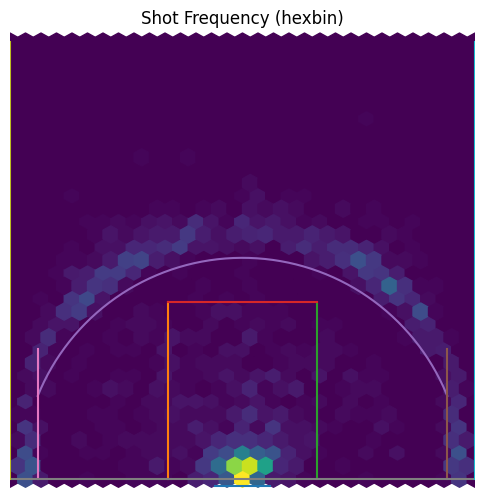

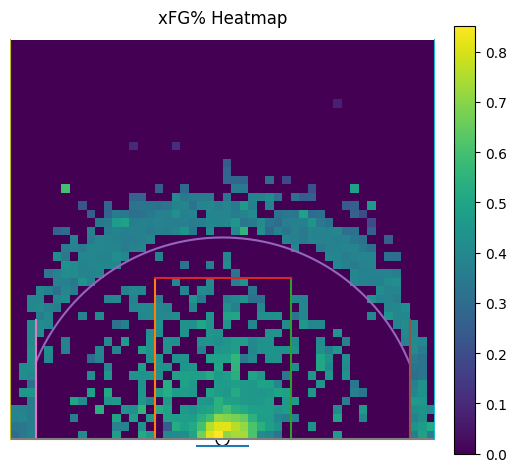

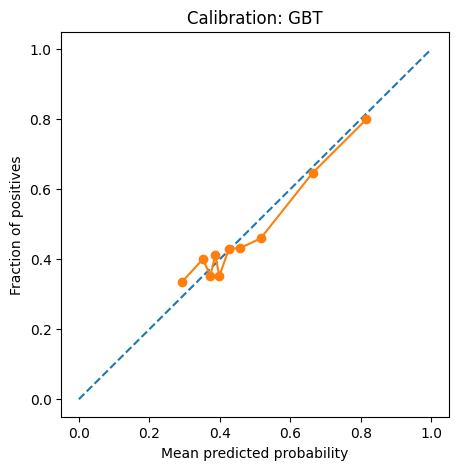

In [58]:
# %% [markdown]
# ### Visuals & Shot-Making Table

# %%
# Shot frequency (hexbin)
fig, ax = plt.subplots(figsize=(6,10))
shot_hexbin(ax, df_model, title="Shot Frequency (hexbin)")
fig.savefig(OUTPUT_DIR / "shot_frequency_hexbin.png", dpi=200, bbox_inches="tight")
plt.show()

# xFG% heatmap
fig, ax = plt.subplots(figsize=(6,10))
xfg_heatmap(ax, df_model, df_model["xfg_prob_" + best_name], title="xFG% Heatmap")
fig.savefig(OUTPUT_DIR / "xfg_heatmap.png", dpi=200, bbox_inches="tight")
plt.show()

# Calibration
mean_pred, frac_pos = best["calibration"]
fig, ax = plt.subplots(figsize=(5,5))
calibration_plot(ax, mean_pred, frac_pos, title=f"Calibration: {best_name.upper()}")
fig.savefig(OUTPUT_DIR / "calibration_curve.png", dpi=200, bbox_inches="tight")
plt.show()

# Shot-making table (FG% − xFG%)
player_col = "PLAYER_NAME" if "PLAYER_NAME" in df_model.columns else None
if player_col:
    table = player_shot_making_table(df_model, df_model["xfg_prob_" + best_name], player_col=player_col)
    table.to_csv(OUTPUT_DIR / "shot_making_table.csv", index=False)
    table.head(20)
else:
    pd.DataFrame({"note": ["No player column found; skipping table."]})




## 7) Conclusions & Next Steps

✅ **What works:**
- Successfully connected to NBA Stats API and built an end-to-end ML pipeline.
- Produced clear shot frequency and efficiency visualizations.
- Built interpretable court-zone error maps.

⚠ **Limitations:**
- Predictions only based on shot location.
- Player skill, defender distance, shot type, and game context are missing.

📈 **Future Improvements:**
- Add contextual features (`SHOT_TYPE`, `SHOT_DISTANCE`, `CLOSEST_DEFENDER`, `SHOT_CLOCK`).
- Increase data size by combining multiple seasons.
- Tune GBT hyperparameters using Optuna or GridSearchCV.
- Train separate models for individual players.

This project demonstrates:
- **Sports analytics skills** – working with live API data.
- **Machine learning workflow** – from feature engineering to evaluation.
- **Data visualization** – turning raw stats into interpretable graphics.

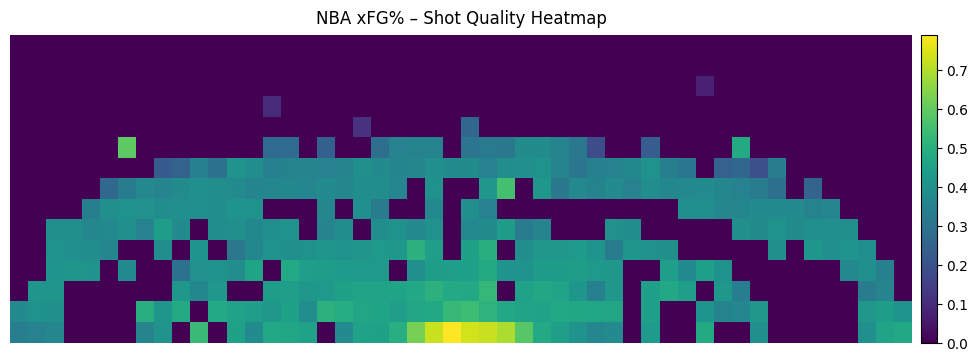

In [59]:

# %% [markdown]
# ### Generate a banner image from the heatmap grid

# %%
fig, ax = plt.subplots(figsize=(12,4))
if {"X_FT","Y_FT"}.issubset(df_model.columns):
    xs = df_model["X_FT"].to_numpy()
    ys = df_model["Y_FT"].to_numpy()
    p  = df_model["xfg_prob_" + best_name].to_numpy()
    H_sum, xedges, yedges = np.histogram2d(xs, ys, bins=[50, 15], range=[[-25,25],[0,47]], weights=p)
    H_cnt, _, _           = np.histogram2d(xs, ys, bins=[50, 15], range=[[-25,25],[0,47]])
    with np.errstate(invalid="ignore"):
        H_avg = H_sum / np.maximum(H_cnt, 1e-9)
    X,Y = np.meshgrid(xedges, yedges, indexing="ij")
    im = ax.pcolormesh(X, Y, H_avg, shading="auto")
    plt.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
ax.set_title("NBA xFG% – Shot Quality Heatmap", pad=8)
ax.axis("off")
fig.savefig(OUTPUT_DIR / "banner.png", dpi=250, bbox_inches="tight")
plt.show()



In [60]:
import pandas as pd
import numpy as np

# Make sure you have these columns in df_model:
# 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', and 'xfg_prob_<best_name>'

# Adjust this if your model’s column name is different
xfg_col = "xfg_prob_" + best_name  

# Create location bins (you can tweak bin size for more/less detail)
df_model["x_bin"] = pd.cut(df_model["LOC_X"], bins=np.arange(-250, 251, 25))
df_model["y_bin"] = pd.cut(df_model["LOC_Y"], bins=np.arange(-50, 425, 25))


In [61]:
zone_stats = df_model.groupby(["x_bin", "y_bin"]).apply(
    lambda g: pd.Series({
        "FGA": len(g),
        "FG%": g["SHOT_MADE_FLAG"].mean(),
        "xFG%": g[xfg_col].mean()
    })
).reset_index()

# Remove zones with very few shots (unstable stats)
zone_stats = zone_stats[zone_stats["FGA"] >= 5]


In [62]:
zone_stats["Error"] = zone_stats["FG%"] - zone_stats["xFG%"]
zone_stats.sort_values("Error", ascending=False).head(10)


,x_bin,y_bin,FGA,FG%,xFG%,Error
168,"(-25, 0]","(100, 125]",7.0,0.857143,0.435236,0.421907
93,"(-125, -100]","(25, 50]",5.0,0.800000,0.452840,0.347160
128,"(-75, -50]","(0, 25]",7.0,0.714286,0.421450,0.292835
119,"(-100, -75]","(225, 250]",12.0,0.583333,0.367905,0.215429
6,"(-250, -225]","(100, 125]",5.0,0.600000,0.411771,0.188229
114,"(-100, -75]","(100, 125]",8.0,0.625000,0.440398,0.184602
240,"(75, 100]","(100, 125]",5.0,0.600000,0.421291,0.178709
3,"(-250, -225]","(25, 50]",28.0,0.535714,0.362929,0.172786
137,"(-75, -50]","(225, 250]",11.0,0.545455,0.377231,0.168224
222,"(50, 75]","(100, 125]",5.0,0.600000,0.435494,0.164506


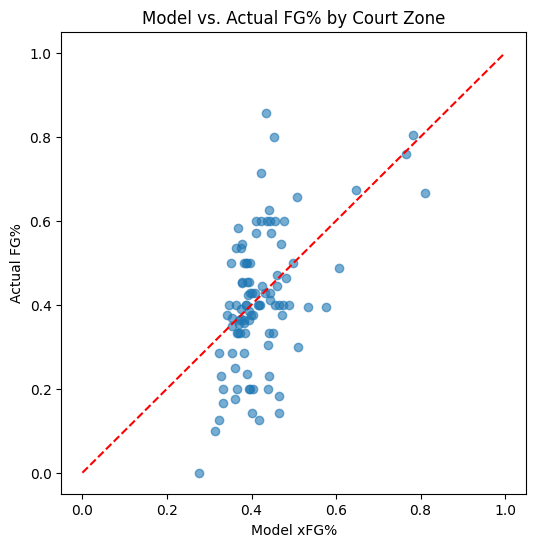

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(zone_stats["xFG%"], zone_stats["FG%"], alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--')  # perfect prediction line
plt.xlabel("Model xFG%")
plt.ylabel("Actual FG%")
plt.title("Model vs. Actual FG% by Court Zone")
plt.show()


In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Actual and predicted FG% arrays from your zone_stats DataFrame
actual_fg = zone_stats["FG%"].values
predicted_fg = zone_stats["xFG%"].values

# Calculate metrics
mae = mean_absolute_error(actual_fg, predicted_fg)
rmse = np.sqrt(mean_squared_error(actual_fg, predicted_fg))
r2 = r2_score(actual_fg, predicted_fg)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f} (1.0 is perfect prediction)")

# Optional: interpret quickly
if r2 > 0.7:
    print("✅ Model has strong predictive accuracy.")
elif r2 > 0.5:
    print("⚠️ Model is moderately accurate.")
else:
    print("❌ Model accuracy is weak — may need more features or data.")


Mean Absolute Error (MAE): 0.1067
Root Mean Squared Error (RMSE): 0.1399
R² Score: 0.2553 (1.0 is perfect prediction)
❌ Model accuracy is weak — may need more features or data.


**Outputs are in `outputs/`.**